# Using a Recurrent Neural Network (RNN) to classify sine wave signals, no tears

[RNNs](https://en.wikipedia.org/wiki/Recurrent_neural_network) are a type of NN appropriate to problems dealing with time. Compare RNNs to Convolutional Neural Networks ([CNNs](https://en.wikipedia.org/wiki/Convolutional_neural_network)), which are appropriate to problems dealing with space. It is said, RNNs are applicable to temporal problems and CNNs are applicable to spatial problems. Specifically, RNNs can be applied to data coming in as sequences to learn 

* how to predict the next item given a previous sequence of data,
* how to classify sequential data, and
* how translate one sequence to another.

Conceptually, the architecture of a RNN is very simple.

* there is an input layer,
* there is a hidden layer, and
* there is an output layer.

However, the way in which an RNN operates to learn is unique. Typically, in feed-forward NN architecture, you feed the input layer to the hidden layer, and then the hidden layer to the output layer. In a RNN, you have to feed the data and hidden inputs into the model; the data input is fed directly to the output layer; the outputs of the hidden layer are fed back into the model (as hidden inputs) in the next cycle. On the first time, the hidden inputs are initialized to zero.

There is one thing to note about the structure of the inputs to a RNN. Imagine you have a list of boy and girl names in English and we want to use a RNN to classify these names into the right gender. Let's say we have a boy name like `John`. How do we encode `John` as an input to a RNN? The answer is with one-hot encoding (__OHE__). We know there are 26 letters in the English alphabet. Since `John` has a length of 4, we can encode it as a 4 x 1 x 26 matrix. 

* The 4 is because `John` is of length four.
* The 1 is because we only are dealing with 1 feature (which is the name).
* The 26 is because there are 26 alphabets.

This type of input data encoding is very popular in NNs, and, as you may have notice, is a multi-dimensional array or matrix. A multi-dimensional matrix is called a __tensor__. So, how would we encode `John` as a tensor? First, we we need to OHE each letter into a vector of length 26. Note the following,

* `J` is the 10-th letter in the alphabet
* `o` is the 15-th letter in the alphabet
* `h` is the 8-th letter in the alphabet
* `n` is the 14-th letter in the alphabet

But, in computer science, we index arrays from zero (causing [off-by-one error](https://en.wikipedia.org/wiki/Off-by-one_error), OBOE). So, when we OHE each letter into its own array, we take its position in the alphabet minus 1. To be clear, the letters in `John` will be OHE as follows.

* `J` in the 9-th position
* `o` in the 14-th position
* `h` in the 7-th position
* `n` in the 13-th position

These OHE vectors will look like the following.


* `J` will be OHE as $[0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]$
* `o` will be OHE as $[0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]$
* `h` will be OHE as $[0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]$
* `n` will be OHE as $[0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]$

Now, I will not visualize the 4 x 1 x 26 matrix, but hopefully, you can more easily understand the OHE scheme that builds towards the tensor used as input for a RNN. (If you are wondering, `J` and `j` may more may not map to the same position; it depends on what you are modeling). In this problem of using a RNN to classify names into gender, what we are saying is that sequences of letters can lead to good predictions of whether a name will be a boy or girl name.

For our case in this notebook, since we have 100 points for a sine wave, we will have a 100 x 1 x 100 tensor. And, in this case, what we are saying is that sequences of $y(t)$ can lead to a good predictions of whether a sine wave will be of one class or another. Apart from our problem, we can use RNNs to learn to classify sine wave data that may represent anything (music, noise, light, etc.). This notebook shows how we can use RNNs to classify synthetic, toy, dummy sine waves.

# Generate data

Here, we generate 3 types of [sine waves](https://en.wikipedia.org/wiki/Sine_wave) according to the equation.

$y(t) = A\sin(2 \pi f t + \varphi) + \epsilon$

where

* $t$ is time
* $A$ is amplitude
* $f$ is frequency
* $\varphi$ is the phase
* $\epsilon$ is an error term normally distributed in $\mathcal{N}(0, 0.02)$

The three types of sine waves have the following parameters.

* $y_0(t) = \sin(2 \pi 10 t) + \epsilon$
* $y_1(t) = 2\sin(2 \pi 10 t) + \epsilon$
* $y_2(t) = \sin(2 \pi 5 t) + \epsilon$

For each sample, there will be 100 data points in the range $[0, 1]$ and will take on the corresponding label (category/class) of the sine wave from which it was sampled. Note that $y_0(t)$ is the baseline sine wave, and has a lower amplitude than $y_1(t)$ and has a larger frequency than $y_2(t)$. This toy problem is, given samples coming from these 3 types of sine waves, can we use a RNN to classify them?

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(37)

def random_sin(a, f, p, start, stop, n, e_mean=0.0, e_var=0.02):
    """
    Gets a sine wave according to y(t) = a sin(2*pi*f*t + p) + e, where
    
    * a = amplitude
    * f = frequency
    * t = time
    * p = phase
    * e = error ~ N(e_mean, e_var); error is normally distributed with mean e_mean and variance e_var.
    
    :param a: Amplitude.
    :param f: Frequency.
    :param p: Phase.
    :param start: Start time (inclusive).
    :param stop: Stop time (inclusive).
    :param n: Number of samples to generate between start and stop.
    :param e_mean: Error mean.
    :param e_var: Error variance.
    :return: Sine wave.
    """
    
    def sin_of(a, f, p, t, e_mean=0.0, e_var=0.02):
        """
        Gets a sine wave according to y(t) = a sin(2*pi*f*t + p) + e, where
    
        * a = amplitude
        * f = frequency
        * t = time
        * p = phase
        * e = error ~ N(e_mean, e_var); error is normally distributed with mean e_mean and variance e_var.

        :param a: Amplitude.
        :param f: Frequency.
        :param p: Phase.
        :param t: Time.
        :param e_mean: Error mean.
        :param e_var: Error variance.
        :return: Sine wave.
        """
        return a * np.sin(2 * np.pi * f * t + p) + np.random.normal(e_mean, e_var)
    
    return np.array([[t, sin_of(a, f, p, t, e_mean, e_var)] for t in np.linspace(start, stop, n)], dtype=np.float)

def get_sin_samples(a, f, p, start, stop, n, total=100, e_mean=0.0, e_var=0.02):
    """
    Gets a sample of sine waves according to y(t) = a sin(2*pi*f*t + p) + e, where
    
    * a = amplitude
    * f = frequency
    * t = time
    * p = phase
    * e = error ~ N(e_mean, e_var); error is normally distributed with mean e_mean and variance e_var.

    :param a: Amplitude.
    :param f: Frequency.
    :param p: Phase.
    :param start: Start time (inclusive).
    :param stop: Stop time (inclusive).
    :param n: Number of samples to generate between start and stop.
    :param total: Total number of samples.
    :param e_mean: Error mean.
    :param e_var: Error variance.
    :return: A sample of sine waves.
    """
    return [random_sin(a, f, p, start, stop, n, e_mean, e_var) for i in range(100)]

This plot shows one example from each of the sine waves.

Text(0,0.5,'$y(t)$')

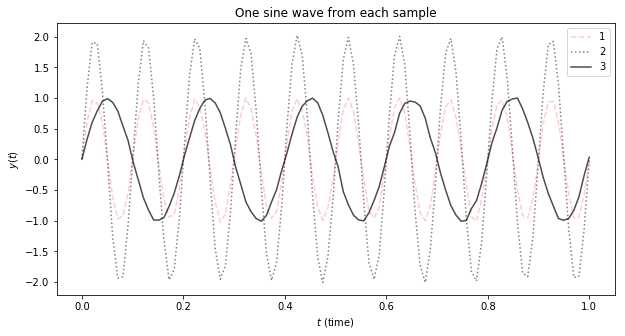

In [2]:
n = 100
total = 100

samples1 = get_sin_samples(a=1, f=10, p=0, start=0, stop=1, n=n, total=total)
samples2 = get_sin_samples(a=2, f=10, p=0, start=0, stop=1, n=n, total=total)
samples3 = get_sin_samples(a=1, f=5, p=0, start=0, stop=1, n=n, total=total)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(samples1[0][:, 0], samples1[0][:, 1], 'r--', label='1', alpha=0.2)
ax.plot(samples2[0][:, 0], samples2[0][:, 1], 'k:', label='2', alpha=0.5)
ax.plot(samples3[0][:, 0], samples3[0][:, 1], 'k', label=3, alpha=0.7)
ax.legend()
ax.set_title('One sine wave from each sample')
ax.set_xlabel(r'$t$ (time)')
ax.set_ylabel(r'$y(t)$')

In [3]:
x1 = np.array([samples1[i][:, 1] for i in range(len(samples1))], dtype=np.float)
x2 = np.array([samples2[i][:, 1] for i in range(len(samples2))], dtype=np.float)
x3 = np.array([samples3[i][:, 1] for i in range(len(samples3))], dtype=np.float)
y1 = np.full((total, 1), 0)
y2 = np.full((total, 1), 1)
y3 = np.full((total, 1), 2)

X = np.vstack([x1, x2, x3])
y = np.vstack([y1, y2, y3])

print(X.shape)
print(y.shape)

(300, 100)
(300, 1)


# Use a RNN to learn from the data

Here we use a RNN to learn from the data. Note that we feed one example at a time randomly to the RNN to learn; this method is known as __stochastic gradient descent__. Also note that we run the learning process for 2,000 iterations.

In [4]:
import torch
import torch.nn as nn

def signal_to_tensor(s):
    """
    Converts a signal to a tensor of type float with n x 1 x n dimension.
    
    :param s: A sine signal.
    :return: A float tensor.
    """
    n = len(s)
    tensor = torch.zeros(n, 1, n, dtype=torch.float)
    for t, y in enumerate(s):
        tensor[t][0][t] = y
    return tensor

def category_to_tensor(y):
    """
    Converts a category/class label to a tensor of type long with 1 x 1 dimension.
    
    :param y: A label.
    :return: A long tensor.
    """
    return torch.tensor([y], dtype=torch.long)

def random_example(X, y):
    """
    Picks a random sample from X and y. Note that X and y are numpy arrays
    but the returned values will be tensors.
    
    :param X: Matrix of sine waves.
    :param y: Matrix of labels.
    :return: A random sample from X, y that are tensors.
    """
    idx = np.random.randint(low=0, high=X.shape[0]-1)
    return get_example(X, y, idx)

def get_example(X, y, idx):
    """
    Selects the sample specified by `idx` and converts it to a pair of tensors.
    
    :param X: Matrix of sine waves.
    :param y: Matrix of labels.
    :param idx: Index (or row) of the matrices to convert.
    :return: A pair of tensors from X, y.
    """
    X_ex = X[idx, :]
    y_ex = y[idx, 0]
    
    X_tensor = signal_to_tensor(X_ex)
    y_tensor = category_to_tensor(y_ex)
    
    return X_tensor, y_tensor

def train_one(X, y, rnn, criterion, learning_rate):
    """
    Does training on one sample.
    
    :param X: A tensor representing a sine wave.
    :param y: A tensor representing a label.
    :param rnn: A RNN model.
    :param criterion: Loss function.
    :param learning_rate: Learning rate.
    :return: Returns the output prediction and loss.
    """
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    for i in range(X.size()[0]):
        output, hidden = rnn(X[i], hidden)

    loss = criterion(output, y)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    
    return output, loss.item()

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [5]:
from tqdm import tqdm

input_size = n
n_hidden = 128
output_size = 3

rnn = RNN(input_size, n_hidden, output_size)
criterion = nn.NLLLoss()
learning_rate = 0.005

n_iters = 2000
plot_every = 100

current_loss = 0
losses = []
iters = []

for i in tqdm(range(1, n_iters + 1)):
    X_tensor, y_tensor = random_example(X, y)
    output, loss = train_one(X_tensor, y_tensor, rnn, criterion, learning_rate)
    current_loss += loss

    if i % plot_every == 0:
        losses.append(current_loss / plot_every)
        iters.append(i)
        current_loss = 0

100%|██████████| 2000/2000 [00:24<00:00, 80.45it/s]


This is a plot of loss over the iterations.

Text(0,0.5,'loss')

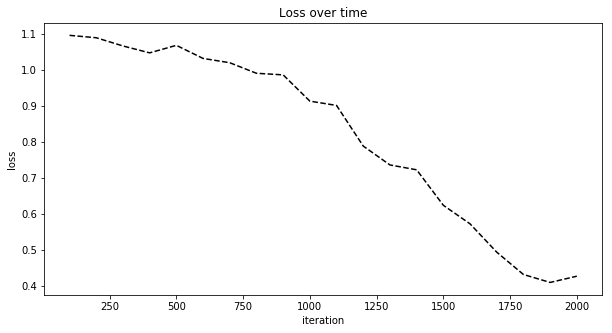

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(iters, losses, 'k--')
ax.set_title('Loss over time')
ax.set_xlabel(r'iteration')
ax.set_ylabel(r'loss')

# Evaluate the RNN

Now, let's evaluate the RNN's performance. We will use the __Brier score__; a lower value means better performance. We will also use multilabel performance metrics such as __coverage error__, __label ranking average precision score__, and __label ranking loss__; with the exception of label ranking loss, a higher score is better.

In [7]:
def evaluate(X, rnn):
    hidden = rnn.initHidden()
    for i in range(X.size()[0]):
        output, hidden = rnn(X[i], hidden)
        
    return output

def predict(X, rnn, n_predictions=3):
    with torch.no_grad():
        output = evaluate(X, rnn)
        
        topv, topi = output.topk(n_predictions, 1, True)
        probs = np.zeros((1, n_predictions))
        
        for i in range(n_predictions):
            v = output[0][i].item()
            c = output[0][i].item()
            e = np.exp(v)
            probs[0][i] = e
            
        probs = probs / np.sum(probs)
        return probs
        
def predict_all(X, y, rnn, n_predictions=3):
    y_pred = np.zeros((X.shape[0], n_predictions))
    y_true = np.zeros((X.shape[0], n_predictions))
    
    for r in range(X.shape[0]):
        p = predict(signal_to_tensor(X[r, :]), rnn)
        for c in range(n_predictions):
            y_pred[r, c] = p[0, c]
        y_true[r, y[r]] = 1.0
    return y_true, y_pred

In [8]:
y_true, y_pred = predict_all(X, y, rnn)

In [9]:
from sklearn.metrics import brier_score_loss, roc_auc_score, coverage_error
from sklearn.metrics import label_ranking_average_precision_score, label_ranking_loss

print('> Brier score')
print(brier_score_loss(y_true[:, 0], y_pred[:, 0]))
print(brier_score_loss(y_true[:, 1], y_pred[:, 1]))
print(brier_score_loss(y_true[:, 2], y_pred[:, 2]))
print('')
print('> Multilabel ranking metrics')
print(coverage_error(y_true, y_pred))
print(label_ranking_average_precision_score(y_true, y_pred))
print(label_ranking_loss(y_true, y_pred))

> Brier score
0.11117179658565038
0.028118959778354095
0.042531551746130984

> Multilabel ranking metrics
1.0
1.0
0.0


# References

* [Sine wave](https://en.wikipedia.org/wiki/Sine_wave)
* [Fourier Transforms](https://docs.scipy.org/doc/scipy/reference/tutorial/fftpack.html)
* [Classifying names with a character-level RNN](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
* [Model evaluation, from binary to multiclass and multilabel](http://scikit-learn.org/stable/modules/model_evaluation.html#from-binary-to-multiclass-and-multilabel)
* [Time sequence prediction](https://github.com/pytorch/examples/tree/master/time_sequence_prediction)

# Take a Look!

Take a look at [Dr. Larry Kerschberg](http://mason.gmu.edu/~kersch/index.html).